###Gestalt Principle of Similarity

The law of similarity states that elements within an assortment of objects are perceptually grouped together if they are similar to each other. This similarity can occur in the form of shape, colour, shading or other qualities. For example, the figure illustrating the law of similarity portrays 36 circles all equal distance apart from one another forming a square. In this depiction, 18 of the circles are shaded dark, and 18 of the circles are shaded light. We perceive the dark circles as grouped together and the light circles as grouped together, forming six horizontal lines within the square of circles. This perception of lines is due to the law of similarity. Reference:Wikipedia

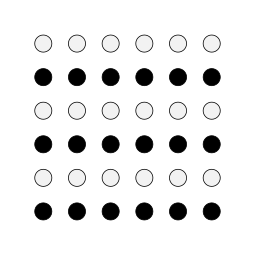

Importing necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# to use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()

Using this class, our training dataset will be generated. In this dataset total 4 types of imgaes will be generated.

1.   Visually grouped by Shape
2.   Visually grouped by Size
3.   Visually grouped by Shade or color
4.   No any particular grouping can be seen



In [2]:
class UnifiedGestaltGenerator:
    def __init__(self, output_dir="similarity_dataset", jitter_range=0.13):
        self.output_dir = output_dir
        self.jitter_range = jitter_range
        os.makedirs(output_dir, exist_ok=True)

        # Main pattern categories
        self.pattern_categories = ['Shape', 'Shading', 'Size', 'Random']
        self.orientations = ['horizontal', 'vertical']

        # Create the four main directories
        self._create_directories()

    def _create_directories(self):
        """Create the four main directories for pattern categories"""
        for category in self.pattern_categories:
            os.makedirs(os.path.join(self.output_dir, category), exist_ok=True)

    def add_position_jitter(self, x, y):
        """Add random jitter to x and y coordinates"""
        jitter_x = np.random.uniform(-self.jitter_range, self.jitter_range)
        jitter_y = np.random.uniform(-self.jitter_range, self.jitter_range)
        return x + jitter_x, y + jitter_y

    def generate_basic_pattern(self, pattern_type, index, grid_size=5):
        """Generate basic patterns with position jitter"""
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.axis('off')

        x_coords, y_coords = np.meshgrid(range(grid_size), range(grid_size))
        x_coords = x_coords.flatten()
        y_coords = y_coords.flatten()

        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            jittered_x, jittered_y = self.add_position_jitter(x, y)

            if pattern_type == "Shape":
                shape = 'circle' if i % 2 == 0 else 'square'
                color = 'black'
                size = 0.2

            elif pattern_type == "Shading":
                shape = 'circle'
                color = 'black' if i % 2 == 0 else 'gray'
                size = 0.2

            elif pattern_type == "Size":
                shape = 'circle'
                color = 'black'
                base_size = 0.1 if i % 2 == 0 else 0.3
                size = base_size * np.random.uniform(0.9, 1.1)

            else:  # mixed (will go to Random folder)
                shape = np.random.choice(['circle', 'square'])
                color = np.random.choice(['black', 'gray'])
                size = np.random.uniform(0.1, 0.3)

            if shape == 'circle':
                circle = plt.Circle((jittered_x, jittered_y), size, color=color)
                ax.add_artist(circle)
            elif shape == 'square':
                square = plt.Rectangle((jittered_x - size, jittered_y - size),
                                    2*size, 2*size, color=color)
                ax.add_artist(square)

        margin = self.jitter_range + 0.5
        ax.set_xlim(-margin, grid_size + margin)
        ax.set_ylim(-margin, grid_size + margin)
        ax.set_aspect('equal')

        # Adjust the target folder based on pattern type
        target_folder = "Random" if pattern_type == "mixed" else pattern_type
        filename = f"basic_{pattern_type.lower()}_{index+1}.png"
        print(filename,"is generated")
        filepath = os.path.join(self.output_dir, target_folder, filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

        return filepath

    def generate_random_pattern(self, index, grid_size=5):
        """Generate a random pattern with no specific grouping"""
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.axis('off')

        n_elements = grid_size * grid_size
        x_coords = np.random.uniform(0, grid_size-1, n_elements)
        y_coords = np.random.uniform(0, grid_size-1, n_elements)

        shapes = ['circle', 'square']
        colors = ['black', 'gray', 'lightgray']
        sizes = [0.15, 0.2, 0.3]

        for x, y in zip(x_coords, y_coords):
            shape = np.random.choice(shapes)
            color = np.random.choice(colors)
            size = np.random.choice(sizes)

            if shape == 'circle':
                circle = plt.Circle((x, y), size, color=color)
                ax.add_artist(circle)
            else:
                rotation = np.random.uniform(0, 360)
                trans = mtransforms.Affine2D().rotate_deg_around(x, y, rotation) + ax.transData
                square = plt.Rectangle((x - size, y - size), 2*size, 2*size,
                                    color=color, transform=trans)
                ax.add_artist(square)

        ax.set_xlim(-1, grid_size)
        ax.set_ylim(-1, grid_size)
        ax.set_aspect('equal')

        filename = f"random_pattern_{index}.png"
        print(filename," is generated")
        filepath = os.path.join(self.output_dir, "Random", filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close(fig)

        return filepath

    def generate_enhanced_pattern(self, pattern_type, orientation, index, grid_size=5):
        """Generate an enhanced pattern with specified type and orientation"""
        if pattern_type == 'Random':
            return self.generate_random_pattern(index, grid_size)

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.axis('off')

        x_coords = np.linspace(0, grid_size-1, grid_size)
        y_coords = np.linspace(0, grid_size-1, grid_size)
        X, Y = np.meshgrid(x_coords, y_coords)
        x_coords = X.flatten().astype(float)
        y_coords = Y.flatten().astype(float)

        jitter = 0.1
        x_coords += np.random.uniform(-jitter, jitter, len(x_coords))
        y_coords += np.random.uniform(-jitter, jitter, len(y_coords))

        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            row = i // grid_size
            col = i % grid_size
            pattern_index = row if orientation == 'horizontal' else col

            if pattern_type == "Shape":
                shapes = ['circle', 'square']
                shape = shapes[pattern_index % 2]
                color = 'black'
                size = 0.3

            elif pattern_type == "Shading":
                shape = 'circle'
                shades = ['black', 'gray', 'lightgray']
                color = shades[pattern_index % 2]
                size = 0.3

            elif pattern_type == "Size":
                shape = 'circle'
                color = 'black'
                sizes = [0.15, 0.3]
                size = sizes[pattern_index % 2]

            if shape == 'circle':
                circle = plt.Circle((x, y), size, color=color)
                ax.add_artist(circle)
            elif shape == 'square':
                rotation_degrees = np.random.uniform(0, 360)
                trans = mtransforms.Affine2D().rotate_deg_around(x, y, rotation_degrees) + ax.transData
                square = plt.Rectangle((x - size, y - size), 2*size, 2*size,
                                    color=color, transform=trans)
                ax.add_artist(square)

        ax.set_xlim(-1, grid_size)
        ax.set_ylim(-1, grid_size)
        ax.set_aspect('equal')

        filename = f"enhanced_{pattern_type.lower()}{orientation}{index}.png"
        print(filename," is generated")
        filepath = os.path.join(self.output_dir, pattern_type, filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close(fig)

        return filepath

    def generate_dataset(self, basic_samples=100, enhanced_samples=50):
        """Generate the complete dataset with both basic and enhanced patterns"""
        metadata = []

        # Generate basic patterns
        print("Generating basic patterns...")
        for pattern_type in ['Shape', 'Shading', 'Size', 'mixed']:
            for i in range(basic_samples):
                filepath = self.generate_basic_pattern(pattern_type, i)
                target_category = "Random" if pattern_type == "mixed" else pattern_type
                metadata.append({
                    'filepath': filepath,
                    'category': target_category,
                    'type': 'basic',
                    'pattern': pattern_type,
                    'orientation': 'grid',
                    'index': i
                })

        # Generate enhanced patterns
        print("Generating enhanced patterns...")
        for pattern_type in ['Shape', 'Shading', 'Size', 'Random']:
            if pattern_type == 'Random':
                for i in range(enhanced_samples * 2):
                    filepath = self.generate_random_pattern(i)
                    metadata.append({
                        'filepath': filepath,
                        'category': 'Random',
                        'type': 'enhanced',
                        'pattern': 'random',
                        'orientation': 'none',
                        'index': i
                    })
            else:
                for orientation in self.orientations:
                    for i in range(enhanced_samples):
                        filepath = self.generate_enhanced_pattern(
                            pattern_type=pattern_type,
                            orientation=orientation,
                            index=i
                        )
                        metadata.append({
                            'filepath': filepath,
                            'category': pattern_type,
                            'type': 'enhanced',
                            'pattern': pattern_type.lower(),
                            'orientation': orientation,
                            'index': i
                        })

        metadata_df = pd.DataFrame(metadata)
        metadata_df.to_csv(os.path.join(self.output_dir, 'metadata.csv'), index=False)
        return metadata_df

if __name__ == "__main__":
    try:
        # Create unified generator
        generator = UnifiedGestaltGenerator(jitter_range=0.13)
        print("Generating complete dataset...")
        metadata = generator.generate_dataset(basic_samples=100, enhanced_samples=50)

        print(f"\nGenerated {len(metadata)} total images")
        print("\n--------Distribution of patterns----------:")
        print("")
        print(metadata.groupby(['category', 'type', 'orientation']).size())

    except Exception as e:
        print(f"An error occurred: {str(e)}")

Generating complete dataset...
Generating basic patterns...
basic_shape_1.png is generated
basic_shape_2.png is generated
basic_shape_3.png is generated
basic_shape_4.png is generated
basic_shape_5.png is generated
basic_shape_6.png is generated
basic_shape_7.png is generated
basic_shape_8.png is generated
basic_shape_9.png is generated
basic_shape_10.png is generated
basic_shape_11.png is generated
basic_shape_12.png is generated
basic_shape_13.png is generated
basic_shape_14.png is generated
basic_shape_15.png is generated
basic_shape_16.png is generated
basic_shape_17.png is generated
basic_shape_18.png is generated
basic_shape_19.png is generated
basic_shape_20.png is generated
basic_shape_21.png is generated
basic_shape_22.png is generated
basic_shape_23.png is generated
basic_shape_24.png is generated
basic_shape_25.png is generated
basic_shape_26.png is generated
basic_shape_27.png is generated
basic_shape_28.png is generated
basic_shape_29.png is generated
basic_shape_30.png is

##Showing some of the images which are generated.

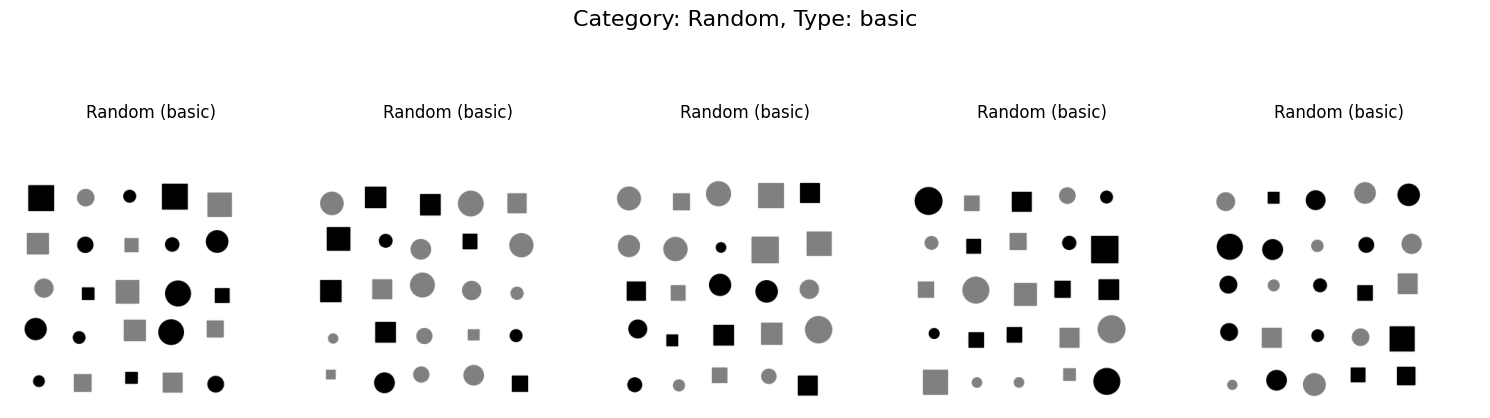

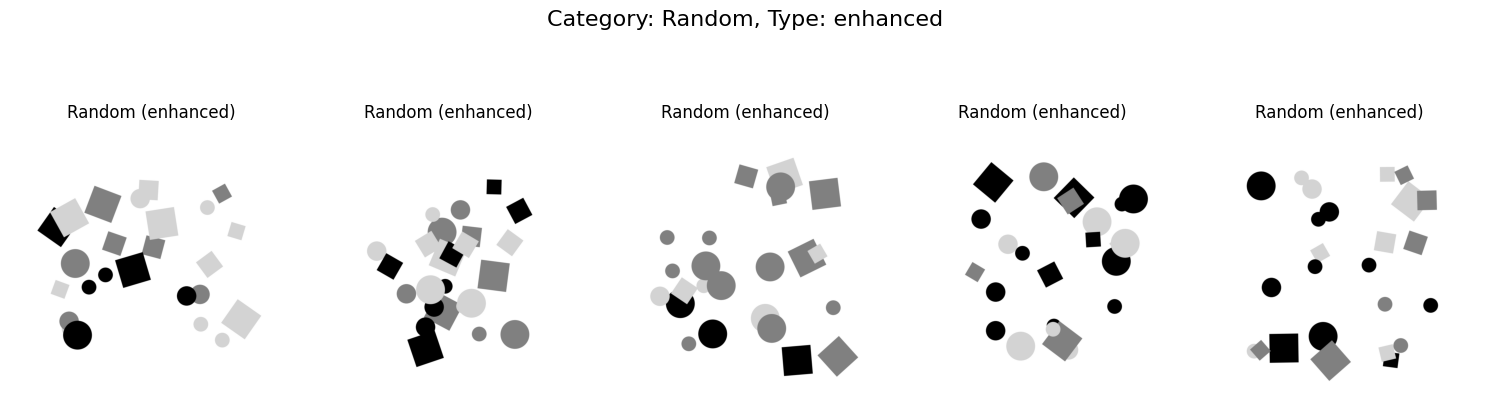

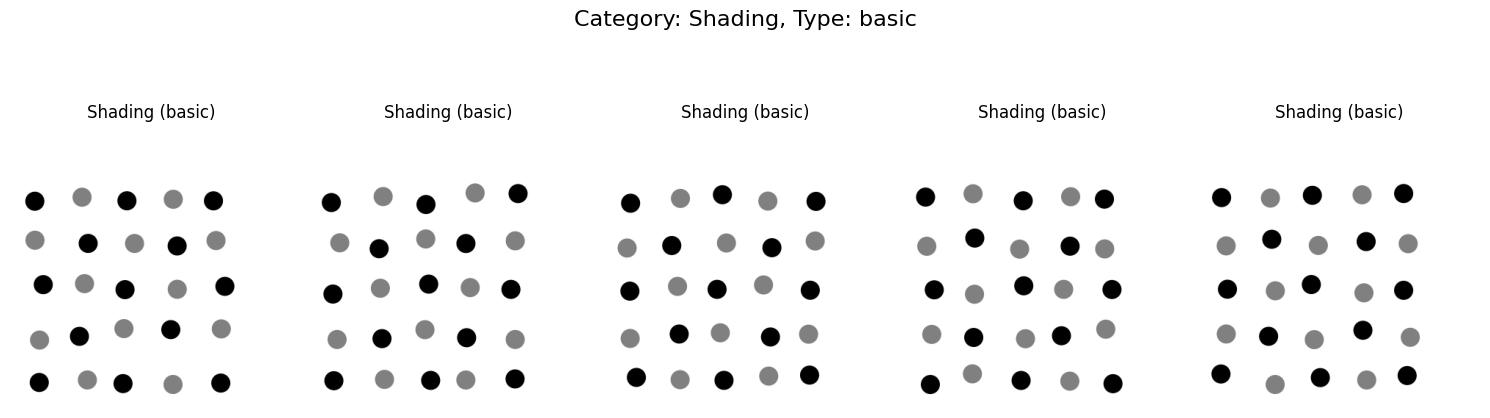

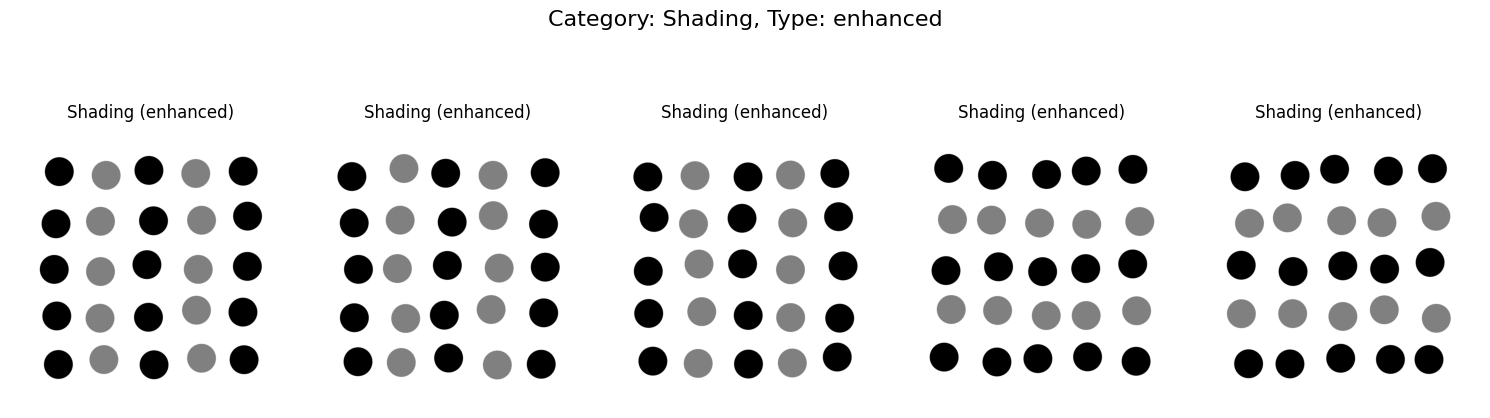

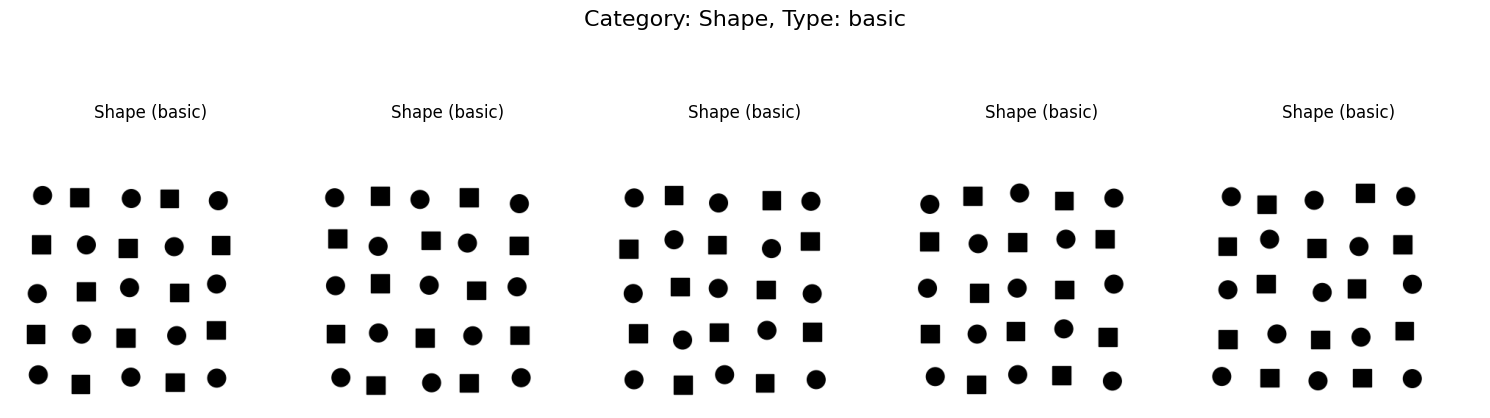

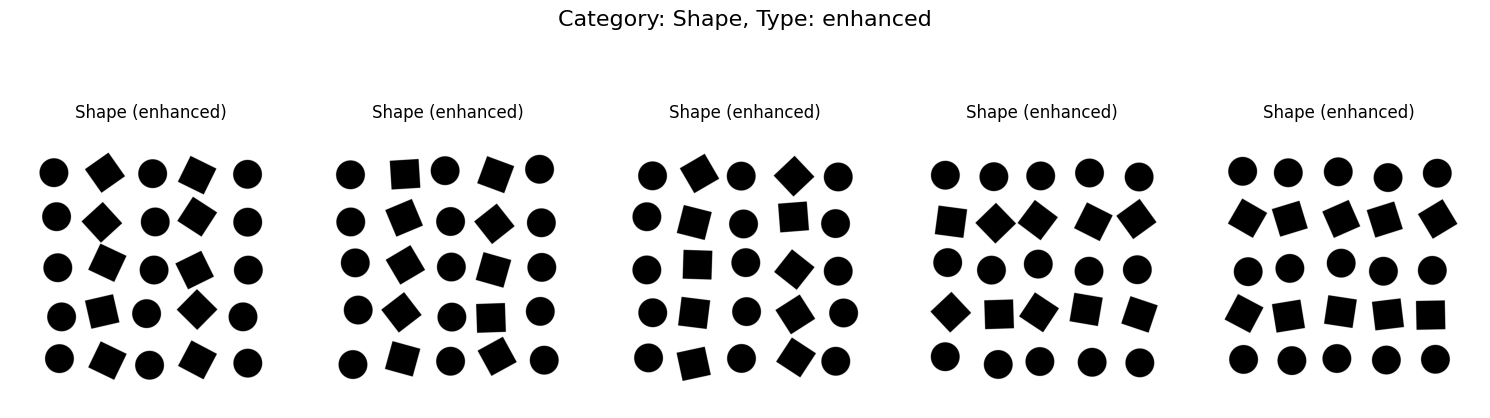

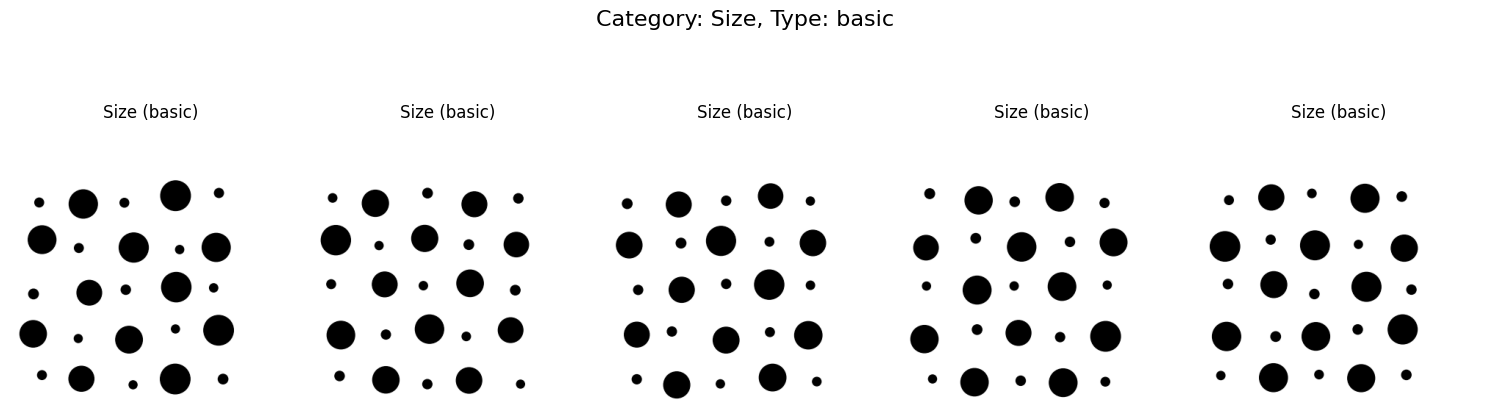

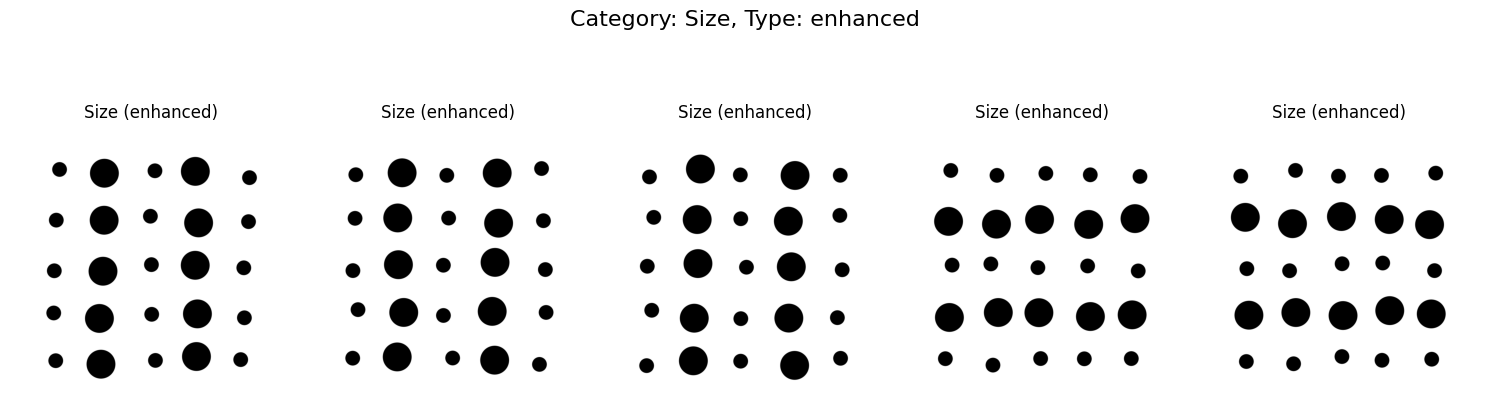

In [3]:
def display_sample_images(metadata_path, output_dir, samples_per_category=5):
    """
    Displays a specified number of sample images for each category and type
    along with their labels.

    Parameters:
        metadata_path (str): Path to the metadata CSV file.
        output_dir (str): Directory where images are stored.
        samples_per_category (int): Number of samples to display per category/type.
    """
    # Load metadata
    metadata_df = pd.read_csv(metadata_path)

    # Group by category and type
    grouped = metadata_df.groupby(['category', 'type'])

    # Iterate through each group and display images
    for (category, pattern_type), group in grouped:
        # Select up to 'samples_per_category' samples from the group
        sample_images = group.sample(n=min(samples_per_category, len(group)), random_state=42)

        # Create a figure for the category and pattern type
        fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
        fig.suptitle(f"Category: {category}, Type: {pattern_type}", fontsize=16)

        for ax, (_, row) in zip(axes, sample_images.iterrows()):
            # Load and display the image
            img_path = row['filepath']
            img = Image.open(img_path)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            # Add label
            ax.set_title(f"{row['category']} ({row['type']})")

        plt.tight_layout()
        plt.show()

# Paths to the metadata and output directory
metadata_path = "similarity_dataset/metadata.csv"
output_dir = "similarity_dataset"

# Display 5 images of every category and type
display_sample_images(metadata_path, output_dir, samples_per_category=5)


## Description of the Below Code

This code provides a framework for generating and applying augmentations to images within a dataset to create a more diverse dataset. Here's a brief breakdown:

1. **`create_metadata_entry(path, category)`**:
   - Creates a metadata dictionary containing the path and category (label) of an image.
   - Helps in tracking augmented images and their associated categories.

2. **`create_augmented_dataset(image_path, category, eval=False)`**:
   - Accepts an image file path, its category, and an optional `eval` flag.
   - Loads the image, converts it to grayscale, and resizes it to 256x256 pixels.
   - Applies a predefined set of augmentations using transformations such as flipping, rotation, and brightness/contrast adjustments. Certain transformations (e.g., larger rotations and higher brightness adjustments) are skipped if `eval` is `False`.
   - Saves the transformed images with filenames that include the augmentation type for traceability.
   - Returns metadata entries for the augmented images.

3. **`augment_all_images(root_dir)`**:
   - Iterates through all images in a specified directory and applies augmentations to images that have not already been augmented (files without a hyphen in their name).
   - Consolidates metadata for all augmented images and saves it as a CSV file (`metadata_new.csv`) in the root directory.

4. **Usage**:
   - Call the `augment_all_images()` function with the root directory of the dataset (`'similarity_dataset'`).
   - The script creates augmented images for each file in the directory structure and stores metadata for further use in tasks like model training or evaluation.

This code ensures dataset diversity by applying transformations systematically and organizing the augmented dataset effectively.

In [4]:
num_img=0
def create_metadata_entry(path, category):
    return {
        'path': path,
        'category': category
    }

def create_augmented_dataset(image_path, category, eval=False):
    """Generate fixed set of augmentations for an image"""
    global num_img
    # Load original image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((256, 256))

    # Get path components
    path, filename = os.path.split(image_path)
    name, ext = os.path.splitext(filename)

    # Define transformations
    transforms_list = {
        'h_flip': transforms.RandomHorizontalFlip(p=1.0),
        'v_flip': transforms.RandomVerticalFlip(p=1.0),
        'rot15': transforms.RandomRotation((0, 15)),
        'rot30': transforms.RandomRotation((16, 30)),
        'rot45': transforms.RandomRotation((31, 45)),
        'rot60': transforms.RandomRotation((46, 60)),
        'bright_up': transforms.ColorJitter(brightness=0.2),
        'contrast_up': transforms.ColorJitter(contrast=0.2),
        'bright_up_up': transforms.ColorJitter(brightness=0.4),
        'contrast_up_up': transforms.ColorJitter(contrast=0.4)
    }

    # Generate and save transformations
    metadata = []
    for transform_name, transform in transforms_list.items():
        # Apply transform
        if transform_name in ['rot45','rot60','bright_up_up','contrast_up_up'] and not eval:
           continue
        transformed = transform(image)

        # Save transformed image
        new_name = f"{name}-{transform_name}{ext}"
        save_path = os.path.join(path, new_name)
        transformed.save(save_path)

        metadata.append(create_metadata_entry(
            save_path, category
        ))
        print(new_name," is generated")
        num_img=num_img+1

    return metadata

def augment_all_images(root_dir):
    """Apply augmentation to all images in directory"""
    metadata = []
    metadata_path = os.path.join(root_dir, 'metadata_new.csv')

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                # Skip if file is already an augmented version
                if '-' not in file:
                    image_path = os.path.join(subdir, file)
                    metadata.extend(create_augmented_dataset(image_path, subdir.split('/')[-1]))

    df = pd.DataFrame(metadata)
    df.to_csv(metadata_path, index=False)

# Usage
augment_all_images('similarity_dataset')
print(num_img)

basic_mixed_75-h_flip.png  is generated
basic_mixed_75-v_flip.png  is generated
basic_mixed_75-rot15.png  is generated
basic_mixed_75-rot30.png  is generated
basic_mixed_75-bright_up.png  is generated
basic_mixed_75-contrast_up.png  is generated
random_pattern_53-h_flip.png  is generated
random_pattern_53-v_flip.png  is generated
random_pattern_53-rot15.png  is generated
random_pattern_53-rot30.png  is generated
random_pattern_53-bright_up.png  is generated
random_pattern_53-contrast_up.png  is generated
random_pattern_66-h_flip.png  is generated
random_pattern_66-v_flip.png  is generated
random_pattern_66-rot15.png  is generated
random_pattern_66-rot30.png  is generated
random_pattern_66-bright_up.png  is generated
random_pattern_66-contrast_up.png  is generated
basic_mixed_89-h_flip.png  is generated
basic_mixed_89-v_flip.png  is generated
basic_mixed_89-rot15.png  is generated
basic_mixed_89-rot30.png  is generated
basic_mixed_89-bright_up.png  is generated
basic_mixed_89-contrast_u

In [5]:
print(num_img," Augmented Images are generated")

4800  Augmented Images are generated


##Below code is showing some of the images which are augmented. also note that augmentaed images are stored in same folder as original

Category: Random


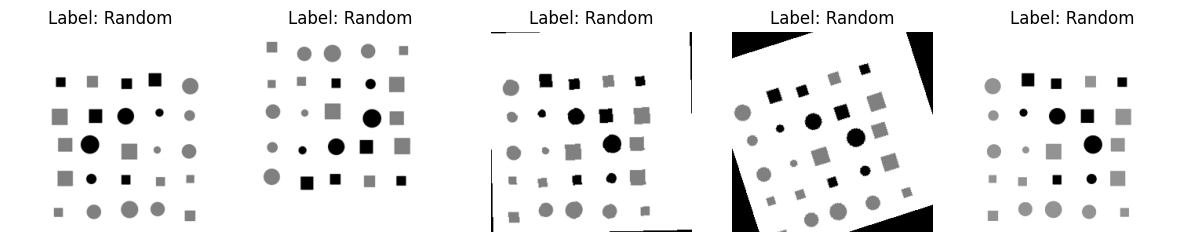

Category: Shading


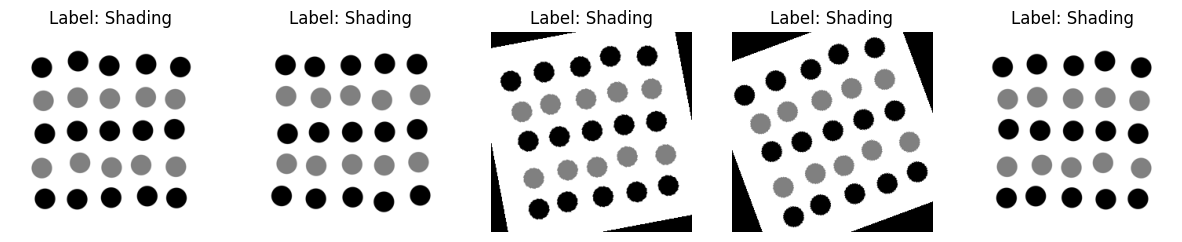

Category: Shape


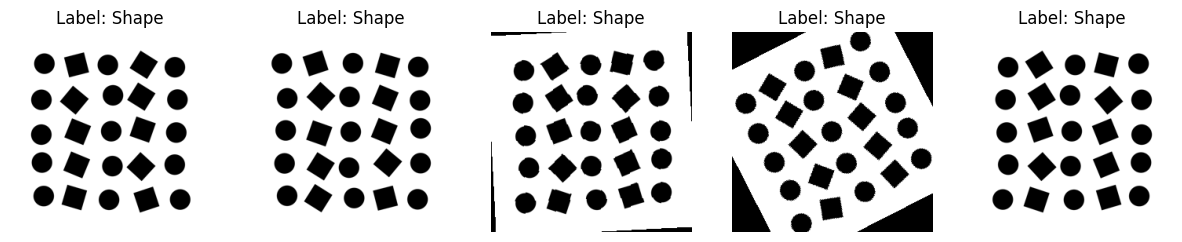

Category: Size


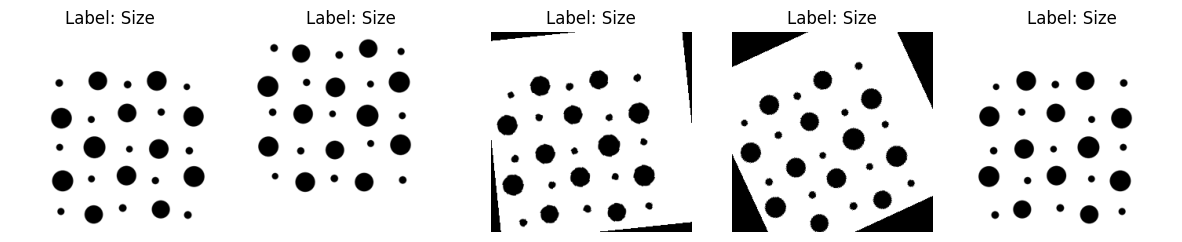

In [6]:
def display_images_from_metadata(metadata_path, num_images=5):
    """Display specified number of images per category from metadata."""
    # Load metadata
    metadata = pd.read_csv(metadata_path)

    # Group by category
    grouped = metadata.groupby('category')

    # Create a figure to display images
    for category, group in grouped:
        print(f"Category: {category}")

        # Select first `num_images` entries in the category
        samples = group.head(num_images)

        # Display the images
        plt.figure(figsize=(15, 5))
        for i, row in samples.iterrows():
            img_path = row['path']
            label = row['category']
            image = Image.open(img_path)

            plt.subplot(1, num_images, (i % num_images) + 1)
            plt.imshow(image, cmap='gray')
            plt.title(f"Label: {label}")
            plt.axis('off')

        plt.show()

# Example Usage
# Replace 'similarity_dataset/metadata_new.csv' with the actual metadata file path
display_images_from_metadata('similarity_dataset/metadata_new.csv', num_images=5)


###The `UnifiedGestaltDataset` class is a custom PyTorch `Dataset` designed to load image data from a DataFrame. It applies specified transformations to the images, encodes categorical labels into numeric form, and returns image-category pairs for model training or evaluation.

In [7]:
class UnifiedGestaltDataset(Dataset):
    def __init__(self, data: pd.DataFrame, transform, encoder):
        self.data = data
        self.transform = transform
        self.encoder = encoder

        self.data['category'] = self.encoder.fit_transform(self.data['category'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.data.iloc[idx, 0]
        image = plt.imread(img_path)

        if self.transform:
            image = self.transform(image)

        category = self.data.iloc[idx, 1]

        return image, category

### It is checking that our system has GPU or not

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Below code is preparing data for a machine learning model, specifically for image processing. Here's what each part does:

1. **`transform` (Image Preprocessing):**  
   - This is a series of steps (called a "pipeline") that transforms images to make them ready for a neural network.  
   - **`ToPILImage()`** – Converts the image to a format that Python can work with.  
   - **`Resize((256, 256))`** – Resizes the image to 256x256 pixels.  
   - **`Grayscale(num_output_channels=1)`** – Converts the image to black and white (grayscale).  
   - **`ToTensor()`** – Changes the image to a tensor (a type of data that the model understands).  
   - **`Normalize((0.5,), (0.5,))`** – Adjusts the pixel values to be between -1 and 1, which helps the model learn better.  

2. **`encoder = LabelEncoder()` (Label Encoding):**  
   - This is used to convert labels (like "cat", "dog") into numbers (like 0, 1).  
   - Machine learning models usually work better with numbers rather than text labels.  

In simple terms, this code prepares images by resizing, converting to black and white, and normalizing them. It also prepares labels by turning them into numbers.

In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

encoder = LabelEncoder()

###Below code is preparing and organizing image data for training a machine learning model. Here's what each part does:

1. **Read and Clean Data:**  
   - `data1` and `data2` are loaded from two CSV files (`metadata.csv` and `metadata_new.csv`).  
   - In `data1`, the column `filepath` is renamed to `path`, and unnecessary columns (`type`, `pattern`, `orientation`, `index`) are removed.  

2. **Combine Datasets:**  
   - The two datasets (`data1` and `data2`) are merged into one (`images`).  
   - The `category` column is cleaned by removing extra spaces, and the data is sorted by category.  
   - The total number of images is printed.  

3. **Prepare for Training:**  
   - `UnifiedGestaltDataset` creates a dataset using the image paths, transformations (`transform`), and label encoder (`encoder`).  
   - The data is split:  
     - 70% for training  
     - 15% for validation  
     - 15% for testing  
   - The sizes of each split are printed.  

4. **Create Data Loaders:**  
   - The data is loaded in batches of 64 images at a time.  
   - `shuffle=True` randomizes the data during loading, helping the model learn better.  

In simple terms, this code organizes image data, splits it into training, validation, and test sets, and prepares it to be fed into a machine learning model in batches.

In [10]:
data1 = pd.read_csv("similarity_dataset/metadata.csv")
data1.rename(columns = {'filepath': 'path'}, inplace=True)
data1.drop(['type', 'pattern', 'orientation', 'index'], axis=1, inplace=True)

data2 = pd.read_csv('similarity_dataset/metadata_new.csv')

images = pd.concat([data1, data2], ignore_index=True)
images['category'] = images['category'].str.strip()
images = images.sort_values(by='category')

print('total images in training dataset:',len(images))

image_data = UnifiedGestaltDataset(images, transform, encoder)

train_len = int(0.7 * len(image_data))
print('Total training images:',train_len)
val_len = int(0.15 * len(image_data))
print('Total validation images:',val_len)
test_len = len(image_data) - train_len - val_len
print('Total testing images:',test_len)

torch.manual_seed(42)

train_data, val_data, test_data = random_split(image_data, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

total images in training dataset: 5600
Total training images: 3919
Total validation images: 840
Total testing images: 841


In [11]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

###Below is a Convolutional Neural Network (CNN) designed to classify images into 4 different categories. Let's break it down piece by piece:

1. Input Processing (conv1):
- The network takes in black and white images (that's why input channels = 1)
- The first layer processes these images using 16 different filters to detect basic patterns
- After filtering, it reduces the image size by half using MaxPool
- ReLU makes sure we keep only positive values
- BatchNorm helps in stabilizing the learning process

2. Further Processing (conv2):
- The second layer takes those 16 channels and processes them into 32 channels
- Again reduces size by half and applies the same type of operations
- This helps in detecting more complex patterns in the image

3. Flattening:
- After the convolution layers, we need to convert our 3D data (32 channels of 64x64 pixels) into a single long line of numbers
- That's why we calculate flat = 32 * 64 * 64

4. First Set of Fully Connected Layers (fc1):
- Takes our flattened data and processes it through two layers
- Goes from flat size → 512 → 128 neurons
- Dropout (0.5) randomly turns off 50% of neurons during training to prevent overfitting
- ReLU activation keeps things non-linear

5. Final Set of Fully Connected Layers (fc2):
- Processes further: 128 → 32 → 4 neurons
- The final 4 neurons correspond to our 4 possible output classes
- Again uses dropout to prevent overfitting

6. Forward Method:
- This is like an assembly line that describes how data flows through our network
- Takes an input image (x)
- Passes it through conv1, conv2
- Flattens it
- Passes through fc1, fc2
- Returns final predictions

Think of it like this: The network first learns to detect simple patterns (edges, corners), then more complex patterns (shapes, textures), and finally combines all this information to make a decision about which of the 4 classes the image belongs to.

The name "Gestalt" in GestaltCNNModel might be referring to the Gestalt principles of perception, suggesting this model might be designed to recognize patterns or forms in a way that mirrors human visual perception.



---



---





### Model Architecture Overview
This CNN model is designed to classify grayscale images into 4 different classes. The architecture consists of convolutional layers followed by fully connected layers.

### Detailed Layer Structure

### 1. First Convolutional Block (conv1)
- Input: Grayscale images (1 channel)
- Operations: Conv2d(1→16) → BatchNorm → ReLU → MaxPool
- Parameters:
  - Conv2d: 144 (3×3×1×16)
  - Bias: 16
  - BatchNorm: 32 (2×16)
  - Total: 192 parameters

### 2. Second Convolutional Block (conv2)
- Input: 16 channel feature maps
- Operations: Conv2d(16→32) → BatchNorm → ReLU → MaxPool
- Parameters:
  - Conv2d: 4,608 (3×3×16×32)
  - Bias: 32
  - BatchNorm: 64 (2×32)
  - Total: 4,704 parameters

### 3. First Fully Connected Block (fc1)
- Input: Flattened tensor (32×64×64 = 131,072)
- Operations: Dropout → Linear → ReLU → Dropout → Linear
- Parameters:
  - First Linear: 67,108,864 (131,072×512) + 512 bias
  - Second Linear: 65,536 (512×128) + 128 bias
  - Total: 67,175,040 parameters

### 4. Second Fully Connected Block (fc2)
- Operations: Dropout → Linear → ReLU → Dropout → Linear
- Parameters:
  - First Linear: 4,096 (128×32) + 32 bias
  - Second Linear: 128 (32×4) + 4 bias
  - Total: 4,260 parameters

### Total Model Parameters
- Total Parameters: 67,184,196
- Majority of parameters (~99.9%) are in the first fully connected layer

## Design Considerations
1. Dropout layers (0.5) are used extensively to prevent overfitting
2. BatchNorm is used in convolutional blocks for training stability
3. The model reduces spatial dimensions through MaxPooling
4. ReLU activation is used throughout for non-linearity

## Input/Output Specifications
- Input: Grayscale images (1 channel)
- Output: 4 classes (logits)



In [12]:
class GestaltCNNModel(nn.Module):
    def __init__(self):
        super(GestaltCNNModel, self).__init__()

        # First conv block: 1->16 channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        # Second conv block: 16->32 channels
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        # Calculate flattened size: 32 channels * 64x64 image size after conv+pool
        self.flat = 32 * 64 * 64

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flat, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128)
        )

        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 4)  # 4 output classes
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.flat)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [13]:
model = GestaltCNNModel()  # Instantiate the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")


Total Trainable Parameters: 67184196


###Below code sets up the training components for the CNN model:

1. `model = GestaltCNNModel().to(device)`: Creates the model and moves it to GPU/CPU
2. `criterion = nn.CrossEntropyLoss()`: Loss function for multi-class classification
3. `optimizer = optim.Adam(...)`: Adam optimizer with:
   - Learning rate: 0.001
   - Weight decay: 0.0001 (helps prevent overfitting)
4. `scheduler`: Reduces learning rate when loss stops improving for 2 epochs
5. `early_stopping`: Stops training if model doesn't improve for 5 epochs

Together, these components form the training pipeline with automatic learning rate adjustment and early stopping to prevent overfitting.

In [14]:
model = GestaltCNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
early_stopping = EarlyStopping(patience=5)

In [16]:
# calculate train loss, train accuracy, val loss, val accuracy for each epoch
train_losses =[]
train_accuracies = []
val_losses = []
val_accuracies = []

for i in range(10):
    model.train()

    val_og_labels = []
    val_pred_labels = []

    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)

        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    with torch.no_grad():
        model.eval()

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss += criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)

            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    scheduler.step(val_loss)

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(100. * (train_correct/train_total))
    val_losses.append(val_loss)
    val_accuracies.append(100. * (val_correct/val_total))

    print(f"Epoch {i+1} - Train Loss: {train_loss}, Train Accuracy: {100. * (train_correct/train_total)}\n \
\tVal Loss: {val_loss}, Val Accuracy: {100. * (val_correct/val_total)}")

    if early_stopping(val_loss):
        break

Epoch 1 - Train Loss: 1.4006961987864586, Train Accuracy: 25.159479459045674
 	Val Loss: 1.3870680332183838, Val Accuracy: 26.785714285714285
Epoch 2 - Train Loss: 1.3788386910192427, Train Accuracy: 25.97601428935953
 	Val Loss: 1.2833021879196167, Val Accuracy: 35.595238095238095
Epoch 3 - Train Loss: 1.2257699754930311, Train Accuracy: 37.02475121204389
 	Val Loss: 0.9976080656051636, Val Accuracy: 62.26190476190476
Epoch 4 - Train Loss: 0.9528341668267404, Train Accuracy: 56.64710385302373
 	Val Loss: 0.6151399612426758, Val Accuracy: 75.47619047619048
Epoch 5 - Train Loss: 0.703805449028169, Train Accuracy: 69.48201071701965
 	Val Loss: 0.4101196229457855, Val Accuracy: 84.52380952380952
Epoch 6 - Train Loss: 0.5575595171220841, Train Accuracy: 76.19290635366166
 	Val Loss: 0.315995454788208, Val Accuracy: 86.78571428571429
Epoch 7 - Train Loss: 0.44955351612260264, Train Accuracy: 80.55626435315132
 	Val Loss: 0.29227229952812195, Val Accuracy: 86.42857142857143
Epoch 8 - Train L

In [23]:
train_losses

[1.4006961987864586,
 1.3788386910192427,
 1.2257699754930311,
 0.9528341668267404,
 0.703805449028169,
 0.5575595171220841,
 0.44955351612260264,
 0.382166656755632,
 0.34394506365060806,
 0.34399605446284814,
 0.3787161707878113]

In [24]:
val_losses

[tensor(1.3871, device='cuda:0'),
 tensor(1.2833, device='cuda:0'),
 tensor(0.9976, device='cuda:0'),
 tensor(0.6151, device='cuda:0'),
 tensor(0.4101, device='cuda:0'),
 tensor(0.3160, device='cuda:0'),
 tensor(0.2923, device='cuda:0'),
 tensor(0.1139, device='cuda:0'),
 tensor(0.2973, device='cuda:0'),
 tensor(0.9287, device='cuda:0')]

In [25]:
# Convert the list of tensors to a list of floats
val_losses = [loss.cpu().item() for loss in val_losses]

In [26]:
val_losses

[1.3870680332183838,
 1.2833021879196167,
 0.9976080656051636,
 0.6151399612426758,
 0.4101196229457855,
 0.315995454788208,
 0.29227229952812195,
 0.11389043927192688,
 0.2973196506500244,
 0.9287266731262207]

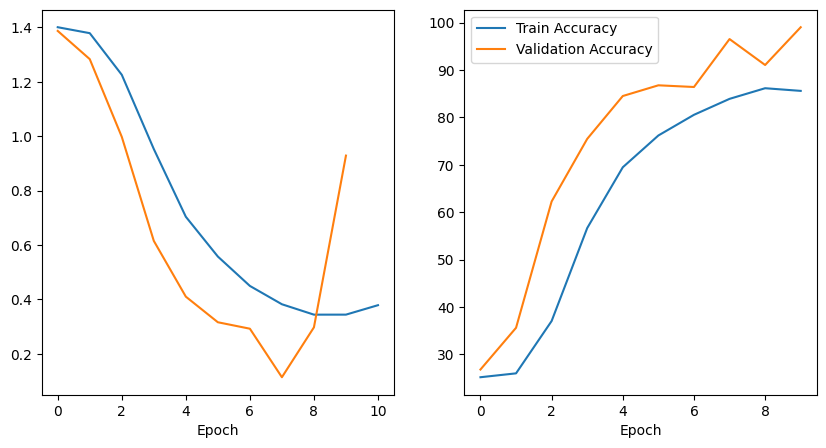

In [27]:
# Plotting the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [28]:
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        test_loss = criterion(outputs, labels)

        _, predicted = outputs.max(1)

        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

In [29]:
100. * test_correct / test_total

98.5731272294887

### Below code is used to save the model weights

In [30]:
torch.save(model.state_dict(), 'gestalt_cnn.pth')

### Create new dataset for testing

In [34]:
class EnhancedGestaltGenerator:
    def __init__(self, output_dir="new_similarity_dataset"):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

        # Add 'random' to pattern types
        self.pattern_types = ['shape', 'shading', 'size', 'random']
        self.orientations = ['horizontal', 'vertical']

        # Create directories for all types including random
        for pattern in self.pattern_types:
            if pattern == 'random':
                os.makedirs(os.path.join(output_dir, pattern), exist_ok=True)
            else:
                for orientation in self.orientations:
                    os.makedirs(os.path.join(output_dir, f"{pattern}_{orientation}"), exist_ok=True)

    def generate_random_pattern(self, index, grid_size=5):
        """Generate a random pattern with no specific grouping"""
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.axis('off')

        # Generate random positions with some constraints to avoid overlapping
        n_elements = grid_size * grid_size
        x_coords = np.random.uniform(0, grid_size-1, n_elements)
        y_coords = np.random.uniform(0, grid_size-1, n_elements)

        # Define possible variations
        shapes = ['circle', 'square']
        colors = ['black', 'gray', 'lightgray']
        sizes = [0.15, 0.2, 0.3]

        for x, y in zip(x_coords, y_coords):
            # Randomly select attributes
            shape = np.random.choice(shapes)
            color = np.random.choice(colors)
            size = np.random.choice(sizes)

            if shape == 'circle':
                circle = plt.Circle((x, y), size, color=color)
                ax.add_artist(circle)
            else:
                rotation = np.random.uniform(0, 360)
                trans = mtransforms.Affine2D().rotate_deg_around(x, y, rotation) + ax.transData
                square = plt.Rectangle((x - size, y - size), 2*size, 2*size,
                                    color=color, transform=trans)
                ax.add_artist(square)

        ax.set_xlim(-1, grid_size)
        ax.set_ylim(-1, grid_size)
        ax.set_aspect('equal')

        filename = f"random_{index}.png"
        print(filename,"is generated")
        filepath = os.path.join(self.output_dir, "random", filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close(fig)

        return filepath

    def generate_pattern(self, pattern_type, orientation, index, grid_size=5):
        """Generate a pattern with specified type and orientation"""
        if pattern_type == 'random':
            return self.generate_random_pattern(index, grid_size)

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.axis('off')

        x_coords = np.linspace(0, grid_size-1, grid_size)
        y_coords = np.linspace(0, grid_size-1, grid_size)
        X, Y = np.meshgrid(x_coords, y_coords)
        x_coords = X.flatten().astype(float)
        y_coords = Y.flatten().astype(float)

        jitter = 0.1
        x_coords += np.random.uniform(-jitter, jitter, len(x_coords))
        y_coords += np.random.uniform(-jitter, jitter, len(y_coords))

        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            row = i // grid_size
            col = i % grid_size

            pattern_index = row if orientation == 'horizontal' else col

            if pattern_type == "shape":
                shapes = ['circle', 'square']
                shape = shapes[pattern_index % 2]
                color = 'black'
                size = 0.3

            elif pattern_type == "shading":
                shape = 'circle'
                shades = ['black', 'gray', 'lightgray']
                color = shades[pattern_index % 2]
                size = 0.3

            elif pattern_type == "size":
                shape = 'circle'
                color = 'black'
                sizes = [0.15, 0.3]
                size = sizes[pattern_index % 2]

            if shape == 'circle':
                circle = plt.Circle((x, y), size, color=color)
                ax.add_artist(circle)
            elif shape == 'square':
                rotation_degrees = np.random.uniform(0, 360)
                trans = mtransforms.Affine2D().rotate_deg_around(x, y, rotation_degrees) + ax.transData
                square = plt.Rectangle((x - size, y - size), 2*size, 2*size,
                                    color=color, transform=trans)
                ax.add_artist(square)

        ax.set_xlim(-1, grid_size)
        ax.set_ylim(-1, grid_size)
        ax.set_aspect('equal')

        filename = f"{pattern_type}_{orientation}_{index}.png"
        print(filename,"is generated")
        filepath = os.path.join(self.output_dir, f"{pattern_type}_{orientation}", filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close(fig)

        return filepath

    def generate_dataset(self, samples_per_class=50):
        """Generate the complete dataset including random patterns"""
        metadata = []

        # Generate patterns for shape, shading, and size
        for pattern_type in self.pattern_types:
            if pattern_type == 'random':
                # Generate random patterns
                for i in range(samples_per_class * 2):  # Generate same number as other classes combined
                    filepath = self.generate_random_pattern(i)

                    metadata.append({
                        'filepath': filepath,
                        'pattern_type': 'random',
                        'orientation': 'none',
                        'index': i
                    })
            else:
                # Generate regular patterns
                for orientation in self.orientations:
                    for i in range(samples_per_class):
                        filepath = self.generate_pattern(
                            pattern_type=pattern_type,
                            orientation=orientation,
                            index=i
                        )
                        metadata.append({
                            'filepath': filepath,
                            'pattern_type': pattern_type,
                            'orientation': orientation,
                            'index': i
                        })

        metadata_df = pd.DataFrame(metadata)
        metadata_df.to_csv(os.path.join(self.output_dir, 'metadata.csv'), index=False)

        return metadata_df

# Example usage
if __name__ == "__main__":
    try:
        generator = EnhancedGestaltGenerator()
        print("Generating dataset...")
        metadata_new = generator.generate_dataset(samples_per_class=50)

        print(f"\nGenerated {len(metadata)} total images")
        print("\nDistribution of patterns:")
        print(metadata_new.groupby(['pattern_type', 'orientation']).size())

    except Exception as e:
        print(f"An error occurred: {str(e)}")

Generating dataset...
shape_horizontal_0.png is generated
shape_horizontal_1.png is generated
shape_horizontal_2.png is generated
shape_horizontal_3.png is generated
shape_horizontal_4.png is generated
shape_horizontal_5.png is generated
shape_horizontal_6.png is generated
shape_horizontal_7.png is generated
shape_horizontal_8.png is generated
shape_horizontal_9.png is generated
shape_horizontal_10.png is generated
shape_horizontal_11.png is generated
shape_horizontal_12.png is generated
shape_horizontal_13.png is generated
shape_horizontal_14.png is generated
shape_horizontal_15.png is generated
shape_horizontal_16.png is generated
shape_horizontal_17.png is generated
shape_horizontal_18.png is generated
shape_horizontal_19.png is generated
shape_horizontal_20.png is generated
shape_horizontal_21.png is generated
shape_horizontal_22.png is generated
shape_horizontal_23.png is generated
shape_horizontal_24.png is generated
shape_horizontal_25.png is generated
shape_horizontal_26.png is

Showing 5 samples of random patterns:


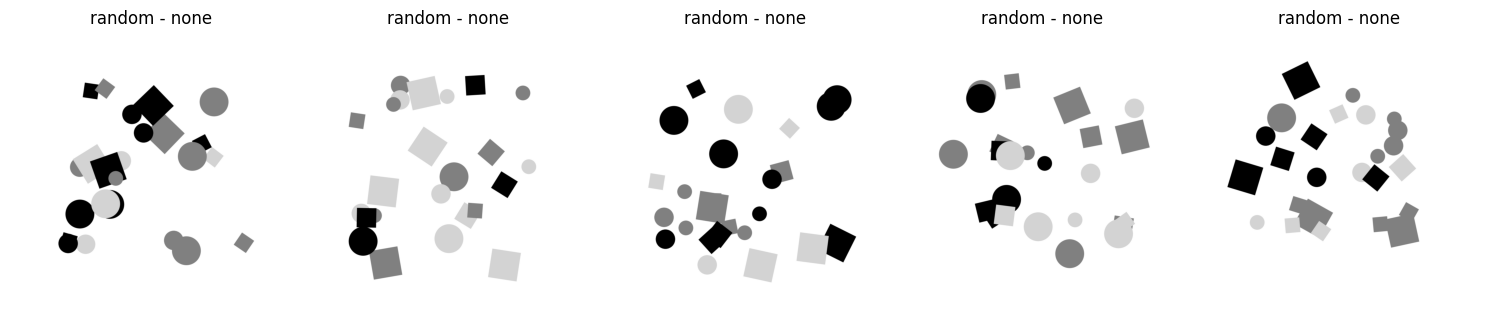

Showing 5 samples of shading - horizontal:


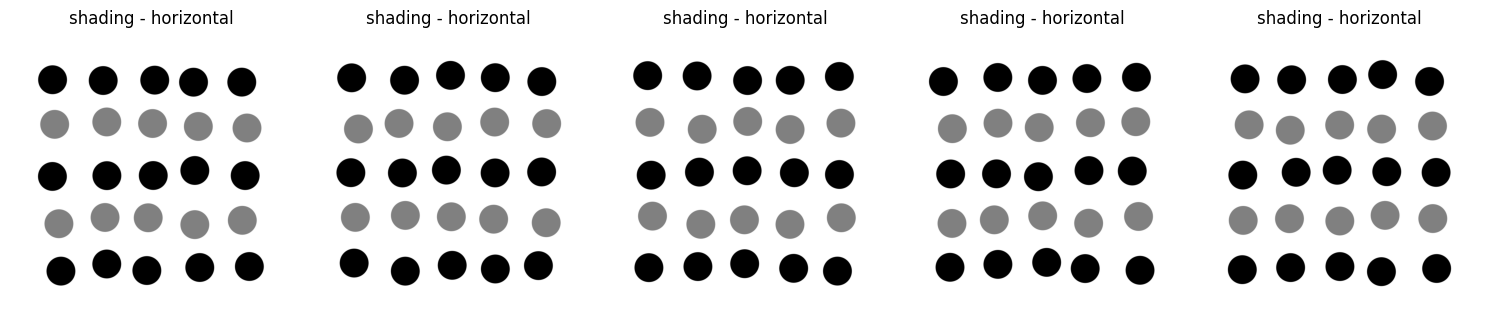

Showing 5 samples of shading - vertical:


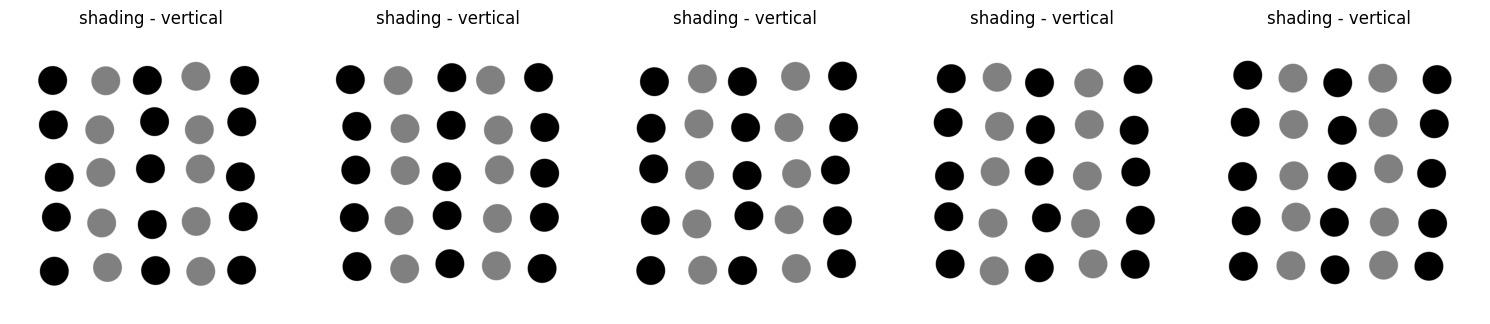

Showing 5 samples of shape - horizontal:


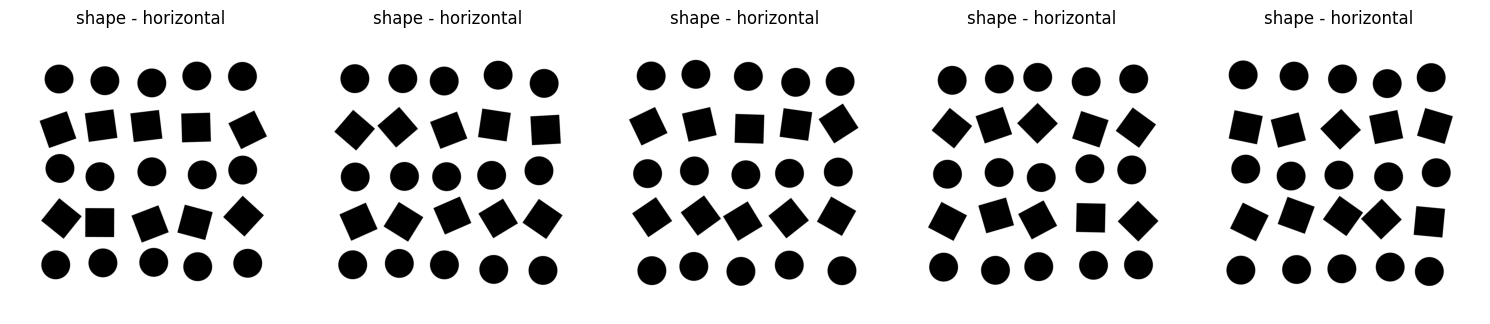

Showing 5 samples of shape - vertical:


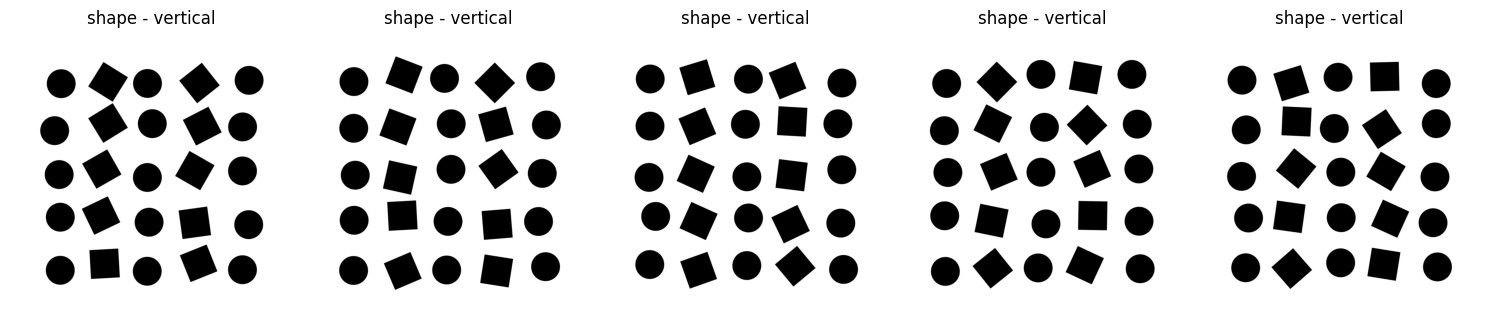

Showing 5 samples of size - horizontal:


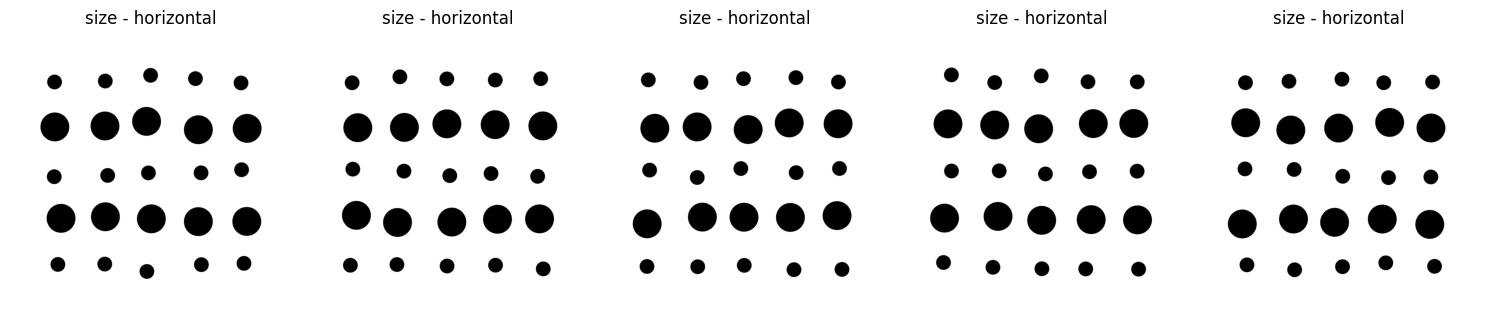

Showing 5 samples of size - vertical:


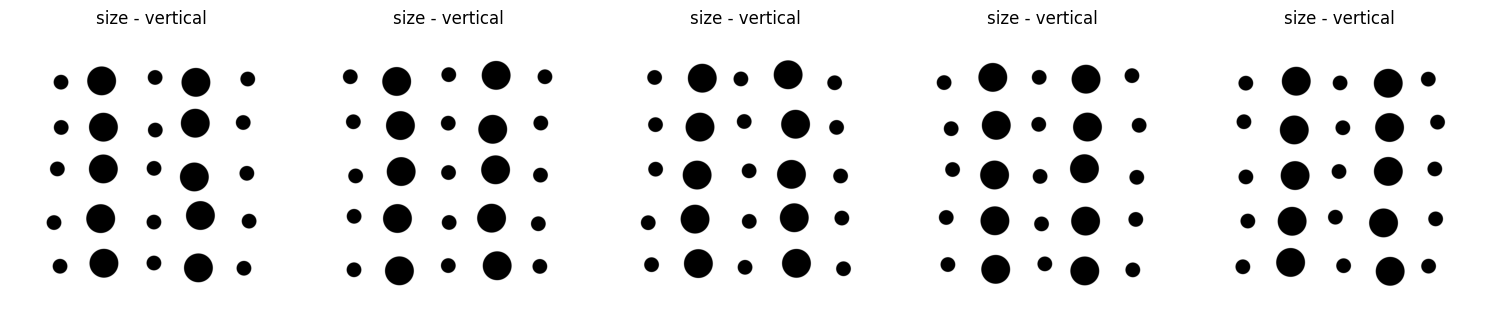

In [35]:
def show_sample_images(metadata, num_samples=5):
    """Display a few sample images for each category and type."""
    grouped = metadata.groupby(['pattern_type', 'orientation'])

    for (pattern_type, orientation), group in grouped:
        if pattern_type == 'random':
            # For random patterns, orientation is always 'none'
            samples = group.sample(n=min(num_samples, len(group)), random_state=42)
            print(f"Showing {len(samples)} samples of random patterns:")
        else:
            samples = group.sample(n=min(num_samples, len(group)), random_state=42)
            print(f"Showing {len(samples)} samples of {pattern_type} - {orientation}:")

        # Plot the samples
        fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
        for ax, (_, row) in zip(axes, samples.iterrows()):
            img = plt.imread(row['filepath'])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"{pattern_type} - {orientation}")
        plt.tight_layout()
        plt.show()


show_sample_images(metadata_new, num_samples=5)



In [ ]:
def augment_all_images_eval(root_dir):
    """Apply augmentation to all images in directory"""
    metadata = []
    metadata_path = os.path.join(root_dir, 'metadata_new.csv')

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                # Skip if file is already an augmented version
                if '-' not in file:
                    image_path = os.path.join(subdir, file)
                    metadata.extend(create_augmented_dataset(image_path, subdir.split('/')[-1].split('_')[0], eval=True))

    df = pd.DataFrame(metadata)
    df.to_csv(metadata_path, index=False)

augment_all_images_eval('new_similarity_dataset')

In [ ]:
data1 = pd.read_csv("new_similarity_dataset/metadata.csv")
data1.rename(columns = {'filepath': 'path', 'pattern_type':'category'}, inplace=True)
data1.drop(['orientation', 'index'], axis=1, inplace=True)

data2 = pd.read_csv('new_similarity_dataset/metadata_new.csv')

metadata_new = pd.concat([data1, data2], ignore_index = True)

In [ ]:
data1['category'].unique(), data2['category'].unique()

(array(['shape', 'shading', 'size', 'random'], dtype=object),
 array(['size', 'shading', 'shape', 'random'], dtype=object))

In [ ]:
metadata_new['category'] = metadata_new['category'].str.capitalize()
metadata_new['category'] = metadata_new['category'].str.strip()
metadata_new = metadata_new.sort_values(by='category')
metadata_new.index = range(0, len(metadata_new))
metadata_new

,path,category
0,enhanced_similarity_dataset/random/random_88-v...,Random
1,enhanced_similarity_dataset/random/random_69-c...,Random
2,enhanced_similarity_dataset/random/random_69-b...,Random
3,enhanced_similarity_dataset/random/random_69-c...,Random
4,enhanced_similarity_dataset/random/random_88-h...,Random
...,...,...
4395,enhanced_similarity_dataset/size_vertical/size...,Size
4396,enhanced_similarity_dataset/size_vertical/size...,Size
4397,enhanced_similarity_dataset/size_vertical/size...,Size
4398,enhanced_similarity_dataset/size_vertical/size...,Size


In [ ]:
print('total images for evalutaion:',len(metadata_new))

total images for evalutaion: 4400


In [ ]:
images = metadata_new.copy()

image_data = UnifiedGestaltDataset(images, transform, encoder)

eval_loader = DataLoader(image_data, batch_size=64, shuffle=True)

In [ ]:
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    model.eval()
    for images, labels in eval_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        test_loss = criterion(outputs, labels)

        _, predicted = outputs.max(1)

        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

    print(f'Eval Loss: {test_loss}, Eval Accuracy: {100. * (test_correct/test_total)}')

Eval Loss: 0.1381249725818634, Eval Accuracy: 92.47727272727273
